#### Setup

In [97]:
import pandas as pd, matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.decomposition import PCA

# Load the data
df = pd.read_csv('accounts.csv')
X = df.drop('deposit', axis=1)
X = pd.get_dummies(X, drop_first=True)
X = X.iloc[:, :8].drop_duplicates().dropna()
Y = pd.get_dummies(df['deposit'], drop_first=True)

#### 1. Normalize the data using MinMaxScaler:

>a. Using sklearn, apply k-means clustering (without targets) on the normalized data with $k=\{2,3,4,5,6,7,8\}$, max_iter=500 and random_state=42. Plot the different sum of squared errors (SSE) using the _inertia attribute of k-means according to the number of clusters.

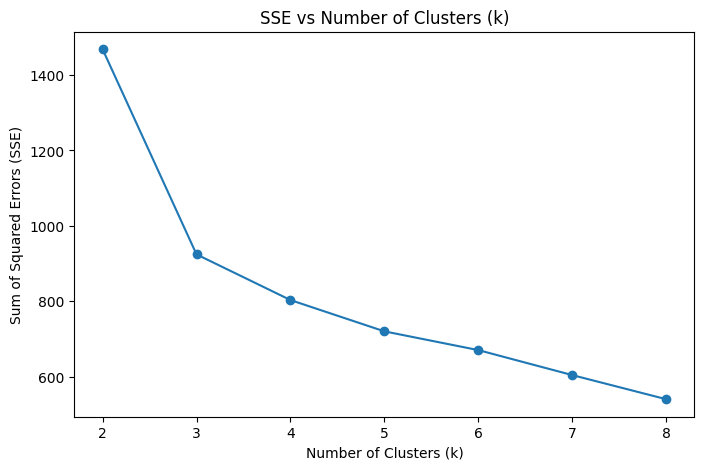

In [98]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

sse = []
k_values = range(2, 9)

# Apply k-means clustering for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k, max_iter=500, random_state=42)
    kmeans.fit_predict(X_normalized)
    sse.append(kmeans.inertia_)
    
# Plot the SSE for each k
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o')
plt.title('SSE vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

>b.  According to the previous plot, how many underlying customer segments (clusters) should there be? Explain based on the trade-off between the clusters and inertia.

According to the plot, and using the knee/elbow finding method we come to the conclusion that the ideal number of clusters is 3. This method consists of finding the point where the decrease in SSE becomes less accentuated with the increase of clusters. 

For all values before this point, the model might suffer from underfitting and for values above, the increase in the number of clusters and complexity does not provide substantial improvements to the model. Not only does it not justify, it also contributes to overfitting the data.


>c. Would k-modes be a better clustering approach? Explain why based on the dataset features.

K-modes is an adaptation of k-means used to handle categorical features. It uses the mode (most frequent value) instead of means to represent the centroid of the cluster and uses distance based in dissimilarity (like Hamming Distance) to group the data.

Given that our dataset's features are predominantly categorical (10 categorical out of 17), in theory, k-modes would be a better clustering approach, considering the explanation above. 

#### 2. Normalize the data using StandardScaler: 

>a. Apply PCA to the data. How much variability is explained by the top 2 components?

In [99]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
pca.fit(X_normalized)

variance_explained = pca.explained_variance_ratio_

print("Variability of 1st principal component:", round(variance_explained[0], 5))
print("Variability of 2nd principal component:", round(variance_explained[1], 5))
print("Variability of both components:", round(variance_explained[1] + variance_explained[0], 5))

Variability of 1st principal component: 0.19568
Variability of 2nd principal component: 0.14462
Variability of both components: 0.3403


>b. Apply k-means clustering with k=3 and random_state=42 (all other arguments as default) and use the original 8 features. Next, provide a scatterplot according to the first 2 principal components. Can we clearly separate the clusters? Justify.

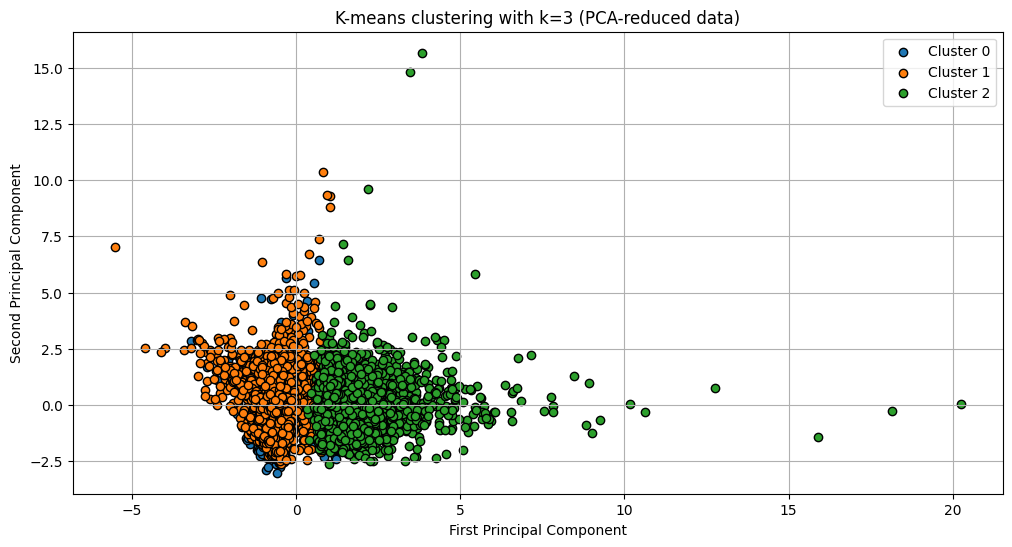

In [108]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_normalized)

X_projected = pca.fit_transform(X_normalized)

plt.figure(figsize=(12, 6))
for cluster in range(3):
    plt.scatter(X_projected[labels == cluster, 0], X_projected[labels == cluster, 1], label=f'Cluster {cluster}', edgecolors='k')
plt.title('K-means clustering with k=3 (PCA-reduced data)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid()
plt.legend()
plt.show()

We can only clearly separate two of the three clusters (the yellow one and the magenta one). The third one (dark blue) is very hard to distinguish from the other two as it underlies both of them. 

This happens because we are losing a lot of information on the data variance by only considering the top two components to draw the plot. The fact that there is significant overlap between some clusters suggests that using only these two components in a 2D space isn’t enough to represent a lot of the variance between the different observations of the dataset, that might become more apparent in higher dimensional spaces.


>c. Plot the cluster conditional features of the frequencies of “job” and ”education” according to the clusters obtained in the previous question (2b.). Use sns.displot (see Data Exploration notebook), with multiple="dodge", stat='density', shrink=0.8 and common_norm=False. Describe the main differences between the clusters in no more than half a page.

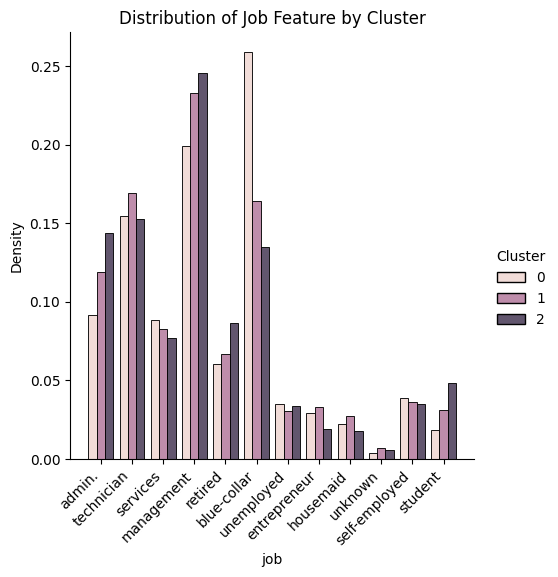

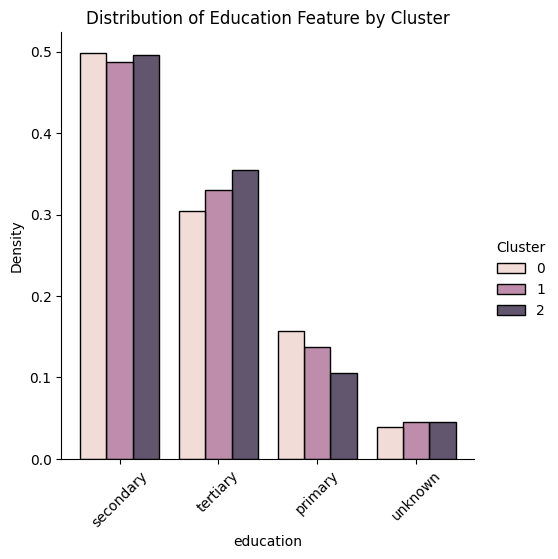

In [101]:
df['Cluster'] = labels

# Plot the 'job' feature distribution across clusters
sns.displot(df, x="job", hue="Cluster", multiple="dodge", stat='density', shrink=0.8, common_norm=False)
plt.title('Distribution of Job Feature by Cluster')
plt.xticks(rotation=45, ha = 'right')
plt.show()

# Plot the 'education' feature distribution across clusters
sns.displot(df, x="education", hue="Cluster", multiple="dodge", stat='density', shrink=0.8, common_norm=False)
plt.title('Distribution of Education Feature by Cluster')
plt.xticks(rotation=45)
plt.show()


The main differences in the obtained plots can be described as follows:

* Jobs
   
   * Cluster 0: Jobs like “blue-collar”, “services”, “unemployed” and “self-employed” appear mostly in this cluster. They can be classified as less qualified positions and working-class jobs.
   
   * Cluster 1: Jobs like “technician”, “entrepreneur”, “housemaid” and “unknown” appear mostly in this cluster. We can’t find a significant relationship between these jobs, which makes us believe this cluster is better described by other features. 
   
   * Cluster 2: Jobs like “admin”, “management”, “retired” and “student” appear mostly in this cluster. They describe either people who are not working or highly qualified jobs

* Education
  
  * Cluster 0: Mostly represented by “primary” and “secondary” levels of education, which translates well to the conclusions we made for the job distribution.
 
  * Cluster 1: Mostly represented by “unknown” level of education, which can also be a good indicator that this cluster might be better represented by other features.
  
  * Cluster 2: Mostly represented by “tertiary” level of education, which also translates well to the conclusions we made for the job distribution.
